<a href="https://colab.research.google.com/github/mawady/cv-recipes/blob/main/ObjectSegmentationPanopticAndSemantic_Infer_Mask2Former_Cityscapes_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# refs:
# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Mask2Former/Inference_with_Mask2Former.ipynb
# https://huggingface.co/facebook/mask2former-swin-tiny-cityscapes-semantic
# https://huggingface.co/facebook/mask2former-swin-tiny-cityscapes-panoptic
# https://huggingface.co/facebook/mask2former-swin-tiny-cityscapes-instance

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# https://drive.google.com/file/d/1kOJ2Hxnm4K4L0H9nAGOytxr9j_j05OfQ/view?usp=sharing
!gdown 1kOJ2Hxnm4K4L0H9nAGOytxr9j_j05OfQ -O input.png
# !wget https://upload.wikimedia.org/wikipedia/commons/b/ba/Broad_Street%2C_Reading.jpg -O input.jpg

Downloading...
From: https://drive.google.com/uc?id=1kOJ2Hxnm4K4L0H9nAGOytxr9j_j05OfQ
To: /content/input.png
100% 868k/868k [00:00<00:00, 82.5MB/s]


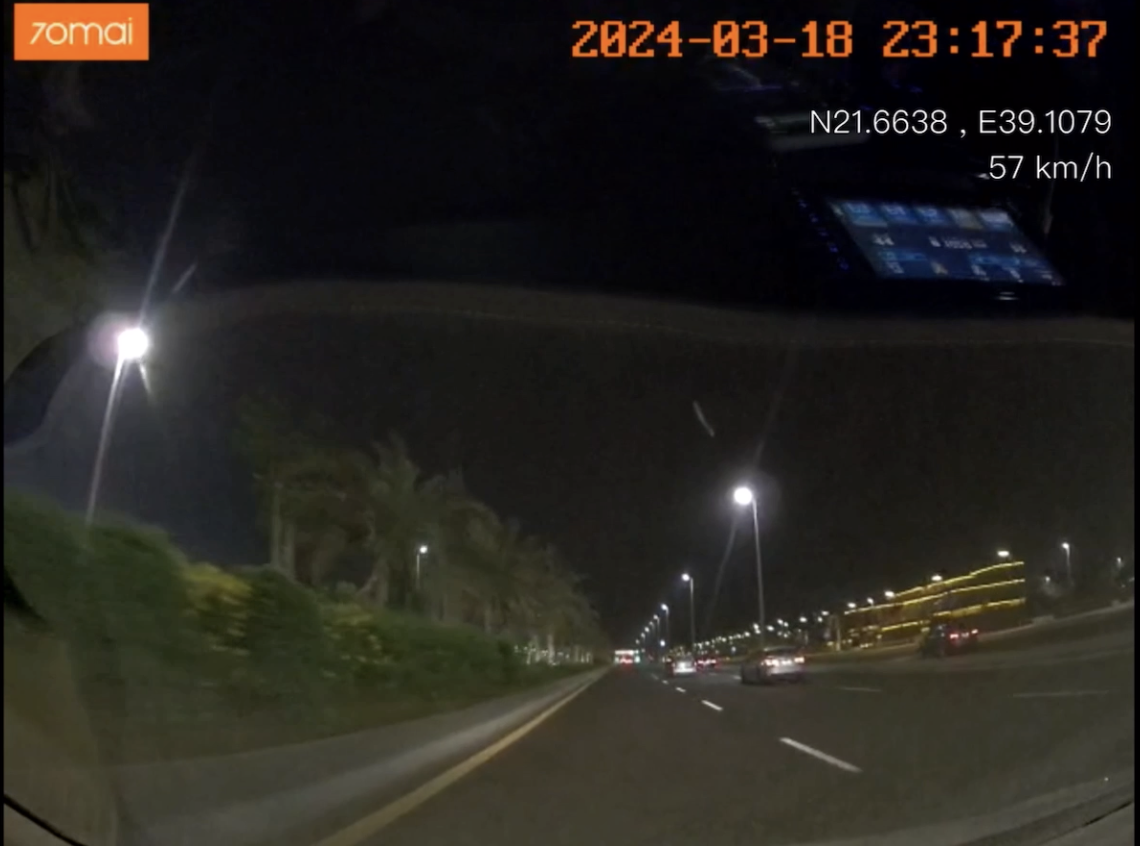

In [ ]:
from PIL import Image
image = Image.open("input.png").convert("RGB")
image

In [ ]:
image.size

(1140, 846)

In [ ]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import torch

# processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-panoptic")

inputs = processor(images=image, return_tensors="pt")
# for k,v in inputs.items():
#   print(k,v.shape)

with torch.no_grad():
  outputs = model(**inputs)

results = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# print(results.keys())

`label_ids_to_fuse` unset. No instance will be fused.


<ipython-input-26-c9c04b2af61c>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


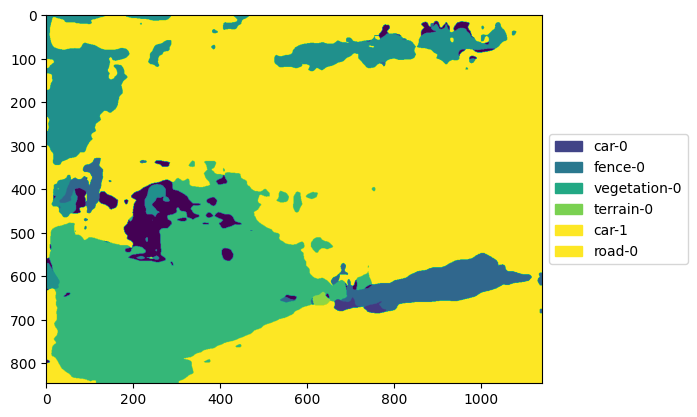

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))

draw_panoptic_segmentation(**results)

In [ ]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import numpy as np

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-semantic")

inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)
predicted_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# print(predicted_map.shape)
color_palette = [list(np.random.choice(range(256), size=3)) for _ in range(len(model.config.id2label))]
# print(color_palette)

preprocessor_config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/77.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/190M [00:00<?, ?B/s]

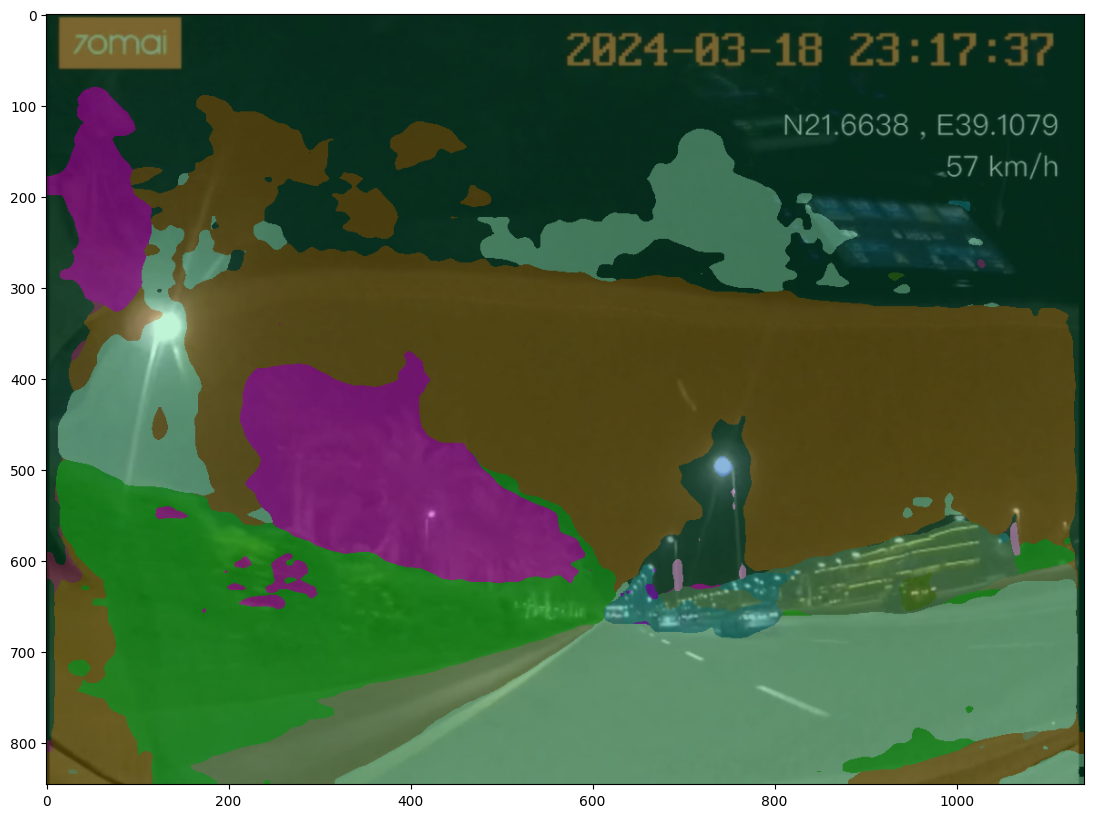

In [ ]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

seg = predicted_map
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(color_palette)
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()